In [14]:
import os
import cv2 as cv
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
device = torch.device("cuda")

In [15]:
def dataset_x(path,data_augmentaion=False):
    pics = os.listdir(path)
    pics_list=[]
    if(data_augmentaion==True):
        for pic in pics:
            img = cv.imread(path+'/'+pic)
            #img = cv.resize(img, (32, 32))
            img = np.array(img)
            img = img/255
            flip_img = np.array(cv.flip(img, 1))
            flip_img=flip_img/255
            equ_img = cv.equalizeHist(cv.cvtColor(img,cv.COLOR_BGR2GRAY))
            equ_img=np.array(cv.cvtColor(equ_img,cv.COLOR_GRAY2BGR))
            equ_img=equ_img/255
            pics_list.append(img)
            pics_list.append(flip_img)
            pics_list.append(equ_img)
    else:
        for pic in pics:
            img = cv.imread(path+'/'+pic)
            img = cv.resize(img, (32, 32))
            img = np.array(img)
            img = img/255
            pics_list.append(img)
    x = torch.Tensor(np.array(pics_list)).permute(0,3,1,2)
    return x

def dataset_y(dataset_x,type):
    size = dataset_x.shape[0]
    y = type*torch.ones([size])
    return y

train_empty_x = dataset_x('/home/hatcher/test/intelligent-information-processing/Chapter7-CNN/CTH/train/empty')
train_people_x = dataset_x('/home/hatcher/test/intelligent-information-processing/Chapter7-CNN/CTH/train/people')
train_train_x = dataset_x('/home/hatcher/test/intelligent-information-processing/Chapter7-CNN/CTH/train/train')
val_empty_x = dataset_x('/home/hatcher/test/intelligent-information-processing/Chapter7-CNN/CTH/val/empty')
val_people_x = dataset_x('/home/hatcher/test/intelligent-information-processing/Chapter7-CNN/CTH/val/people')
val_train_x = dataset_x('/home/hatcher/test/intelligent-information-processing/Chapter7-CNN/CTH/val/train')
test_empty_x = dataset_x('/home/hatcher/test/intelligent-information-processing/Chapter7-CNN/CTH/test/empty')
test_people_x = dataset_x('/home/hatcher/test/intelligent-information-processing/Chapter7-CNN/CTH/test/people')
test_train_x = dataset_x('/home/hatcher/test/intelligent-information-processing/Chapter7-CNN/CTH/test/train')
train_empty_y = dataset_y(train_empty_x,0)
train_people_y = dataset_y(train_people_x,1)
train_train_y = dataset_y(train_train_x,2)
val_empty_y = dataset_y(val_empty_x,0)
val_people_y = dataset_y(val_people_x,1)
val_train_y = dataset_y(val_train_x,2)
test_empty_y = dataset_y(test_empty_x,0)
test_people_y = dataset_y(test_people_x,1)
test_train_y = dataset_y(test_train_x,2)

In [16]:
import torch.utils.data as Data
batch_size = 48# 将训练数据的特征和标签组合
train_dataset = Data.TensorDataset(train_empty_x,train_empty_y)+Data.TensorDataset(train_people_x,train_people_y)+Data.TensorDataset(train_train_x,train_train_y)
val_dataset = Data.TensorDataset(val_empty_x,val_empty_y)+Data.TensorDataset(val_train_x,val_train_y)+Data.TensorDataset(val_people_x,val_people_y)
test_dataset = Data.TensorDataset(test_empty_x,test_empty_y)+Data.TensorDataset(test_people_x,test_people_y)+Data.TensorDataset(test_train_x,test_train_y)
# 把 dataset 放入 DataLoader
train_iter = Data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,num_workers=2)
val_iter = Data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True,num_workers=2)
test_iter = Data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True,num_workers=2)

In [17]:
class ResidualBlock(nn.Module):
    def __init__(self,inchannel,outchannel,stride=1):
        super(ResidualBlock,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(inchannel,outchannel,kernel_size=3,padding=1,stride=stride),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel,outchannel,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(outchannel),
        )
        self.conv1x1 = nn.Sequential( 
            nn.Conv2d(inchannel,outchannel,kernel_size=1,stride=stride),
            nn.BatchNorm2d(outchannel)
            )
    def forward(self,X):
        Y = self.conv(X)
        X = self.conv1x1(X)
        out = F.relu(X+Y)
        return out

In [18]:
block1 =  ResidualBlock(64,64,1)
block2 =  ResidualBlock(64,64,1)
block3 =  ResidualBlock(64,128,2)
block4 =  ResidualBlock(128,128,1)
block5 =  ResidualBlock(128,256,2)
block6 =  ResidualBlock(256,256,1)
block7 =  ResidualBlock(256,512,2)
block8 =  ResidualBlock(512,512,1)

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet,self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(kernel_size=3,in_channels=3,out_channels=64,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            block1,block2,block3,block4,block5,block6,block7,block8
        )
        self.classifier = nn.Sequential(
            #nn.AdaptiveAvgPool2d((1,1)),
            #nn.Flatten(),
            nn.Linear(512,3)
        )
    
    def forward(self,X):
        features = self.features(X)
        out = F.avg_pool2d(features, features.shape[2])
        out = out.squeeze()
        out = self.classifier(out)
        return out

In [19]:
def evaluate_accuracy(data_iter, net, loss):
    acc_sum, n = 0.0, 0
    test_l_sum = 0.0
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        y_hat = y_hat.squeeze()
        acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        l = loss(y_hat, y.long()).sum()
        test_l_sum += l.item()
        n += y.shape[0]
    return acc_sum/n, test_l_sum/n

In [20]:
def train(net,train_iter,val_iter,loss,num_epochs,optimizer):
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
        if(val_acc>0.99):
            return train_loss,val_loss,train_accuracy,val_accuracy
    return train_loss,val_loss,train_accuracy,val_accuracy

In [21]:
import matplotlib.pyplot as plt
import numpy as np
def visualization(train_loss,val_loss,train_accuracy,val_accuracy):
    plt.figure(1)
    x1=np.linspace(0,len(train_loss),len(train_loss))
    plt.plot(x1,train_loss,label='train_loss',linewidth=1.5)
    plt.plot(x1,val_loss,label='test_loss',linewidth=1.5)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

    plt.figure(2)
    x2 = np.linspace(0,len(train_accuracy),len(train_accuracy))
    plt.plot(x2,train_accuracy,label='train_accuracy',linewidth=1.5)
    plt.plot(x2,val_accuracy,label='val_accuracy',linewidth=1.5)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()    
    plt.show()

In [38]:
num_epochs=100
lr=0.01
loss=nn.CrossEntropyLoss()

In [39]:
net = ResNet()
net.to(device)
optimizer=optim.Adam(net.parameters(),lr,weight_decay=1e-5)
for params in net.parameters():
    nn.init.normal_(params,mean=0,std=0.01)

In [40]:
train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_iter,val_iter,loss,num_epochs,optimizer)

epoch1,loss0.0056,train acc 0.882321,val acc 0.827
epoch2,loss0.0021,train acc 0.956500,val acc 0.888
epoch3,loss0.0013,train acc 0.979071,val acc 0.896
epoch4,loss0.0008,train acc 0.986357,val acc 0.908
epoch5,loss0.0006,train acc 0.990036,val acc 0.894
epoch6,loss0.0005,train acc 0.993536,val acc 0.902
epoch7,loss0.0004,train acc 0.994464,val acc 0.921
epoch8,loss0.0005,train acc 0.993429,val acc 0.908
epoch9,loss0.0004,train acc 0.994679,val acc 0.914
epoch10,loss0.0004,train acc 0.994429,val acc 0.919
epoch11,loss0.0003,train acc 0.997000,val acc 0.939
epoch12,loss0.0003,train acc 0.995250,val acc 0.916
epoch13,loss0.0002,train acc 0.997000,val acc 0.912
epoch14,loss0.0002,train acc 0.996857,val acc 0.913
epoch15,loss0.0003,train acc 0.995607,val acc 0.947
epoch16,loss0.0003,train acc 0.996500,val acc 0.944
epoch17,loss0.0002,train acc 0.997786,val acc 0.937
epoch18,loss0.0002,train acc 0.997286,val acc 0.912
epoch19,loss0.0002,train acc 0.996929,val acc 0.906
epoch20,loss0.0002,tr

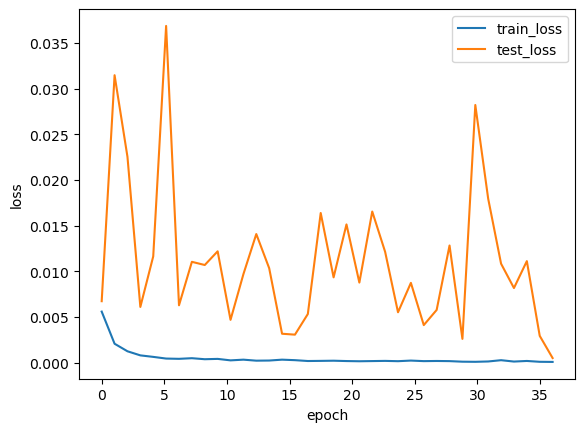

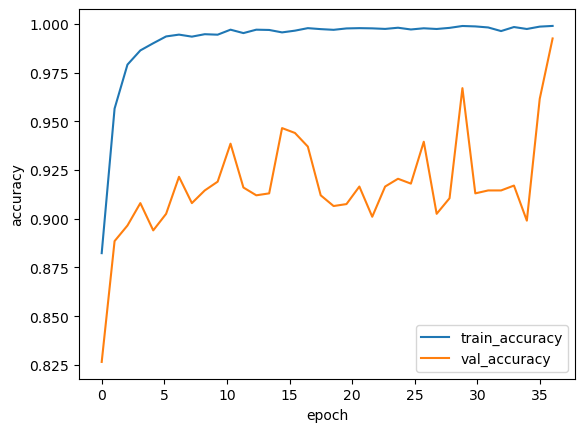

In [41]:
visualization(train_loss,val_loss,train_accuracy,val_accuracy)

In [42]:
test_acc,_ = evaluate_accuracy(test_iter,net,loss)
print("在测试集上的准确率为:%.3f"%(test_acc))

在测试集上的准确率为:0.993


In [44]:
torch.save(net.state_dict(), 'resnet.pth')